In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import jax
import jax.numpy as jnp
from jax import grad, vmap, jit
from jax import random

import numpy as np

import gpx
from gpx.models import SGPR_RPChol
from gpx.kernels import SquaredExponential
from gpx.parameters import Parameter
from gpx.priors import NormalPrior
from gpx.utils import softplus, inverse_softplus, identity

import matplotlib.pyplot as plt

plt.style.use("dark_background")

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


We use the same data as for the SGPR example notebook.
Note that we do not choose the landmarks a priori.
Instead, they are chosen automatically by performing the RPCholesky decomposition of the kernel matrix $K$.

The RPCholesky decomposition iteratively builds a Nystrom approximation for the kernel matrix $K$:

$$\hat{K} = K_{nm} K_{mm}^{-1} K_{mn}$$

where $K_{nm}$ is the kernel matrix evaluated between all the $n$ points and $m$ chosen landmarks.
RPCholesky selects these landmarks as the $m$ pivots used in an uncomplete Cholesky decomposition of $K$.
At variance with diagonal pivoting, which selects the largest element of the diagonal as pivot, RPCholesky samples the diagonal element giving some probability weight also to smaller elements. It is then more robust to outliers. See [1](https://arxiv.org/pdf/2207.06503.pdf)

\[1\]: Yifan Chen, Ethan N. Epperly, Joel A. Tropp,andRobert J. Webber
       "Randomly pivoted Cholesky: Practical approximation of a kernel matrix with few entry evaluations"
       (2023) arXiv:2207.06503v4

In [3]:
def func(x):
    """Latent function."""
    return (
        1.0 * jnp.sin(x * 3 * jnp.pi)
        + 0.3 * jnp.cos(x * 9 * jnp.pi)
        + 0.5 * jnp.sin(x * 7 * jnp.pi)
    )


# Number of training examples
n = 1000

# Noise
sigma_y = 0.2

# Noisy training data
X = jnp.linspace(-1.0, 1.0, n).reshape(-1, 1)
y = func(X) + sigma_y * random.normal(random.PRNGKey(0), shape=(n, 1))

# Test data
X_test = np.linspace(-1.5, 1.5, 1000).reshape(-1, 1)
f_true = func(X_test)

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


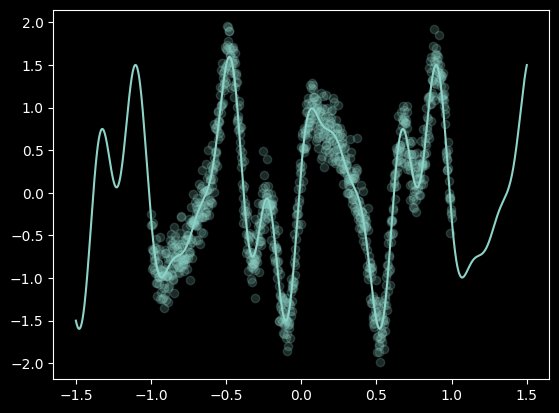

In [4]:
plt.scatter(X, y, alpha=0.2)
plt.plot(X_test, f_true)

In [5]:
model = SGPR_RPChol(
    kernel=SquaredExponential(),
    n_locs=15,                    # how many landmarks we want
    key=jax.random.PRNGKey(2023), # RPCholesky is randomized, so provide a key for that
)

In [6]:
model.print()

┌────────────────────┬─────────────┬───────────┬──────────────────┬──────────────────┬───────────┬─────────┬─────────┬─────────┐
│ name               │ trainable   │ forward   │ backward         │ prior            │ type      │ dtype   │ shape   │   value │
├────────────────────┼─────────────┼───────────┼──────────────────┼──────────────────┼───────────┼─────────┼─────────┼─────────┤
│ kernel lengthscale │ True        │ softplus  │ inverse_softplus │ Normal(0.0, 1.0) │ ArrayImpl │ float64 │ ()      │       1 │
├────────────────────┼─────────────┼───────────┼──────────────────┼──────────────────┼───────────┼─────────┼─────────┼─────────┤
│ sigma              │ True        │ softplus  │ inverse_softplus │ Normal(0.0, 1.0) │ ArrayImpl │ float64 │ ()      │       1 │
└────────────────────┴─────────────┴───────────┴──────────────────┴──────────────────┴───────────┴─────────┴─────────┴─────────┘


In [7]:
model.fit(X, y)

In [8]:
model.print()

┌────────────────────┬─────────────┬───────────┬──────────────────┬──────────────────┬───────────┬─────────┬─────────┬──────────┐
│ name               │ trainable   │ forward   │ backward         │ prior            │ type      │ dtype   │ shape   │    value │
├────────────────────┼─────────────┼───────────┼──────────────────┼──────────────────┼───────────┼─────────┼─────────┼──────────┤
│ kernel lengthscale │ True        │ softplus  │ inverse_softplus │ Normal(0.0, 1.0) │ ArrayImpl │ float64 │ ()      │ 0.113579 │
├────────────────────┼─────────────┼───────────┼──────────────────┼──────────────────┼───────────┼─────────┼─────────┼──────────┤
│ sigma              │ True        │ softplus  │ inverse_softplus │ Normal(0.0, 1.0) │ ArrayImpl │ float64 │ ()      │ 0.308062 │
└────────────────────┴─────────────┴───────────┴──────────────────┴──────────────────┴───────────┴─────────┴─────────┴──────────┘


In [9]:
y_pred, cov_pred = model.predict(X_test, full_covariance=True)
err = 2 * jnp.diag(cov_pred) ** 0.5

# model prediction at input locations
y_locs_pred = model.predict(model.x_locs_)

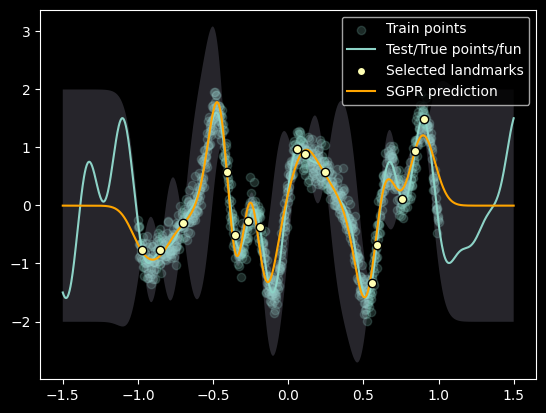

In [10]:
plt.scatter(X, y, alpha=0.2, label="Train points")
plt.plot(X_test, f_true, label="Test/True points/fun")
plt.scatter(model.x_locs_, func(model.x_locs_), zorder=99, ec="k", label="Selected landmarks")
# plt.scatter(
#     model.x_locs_, y_locs_pred, ec="k", zorder=99, label="Final inducing points"
# )
plt.plot(X_test, y_pred, c="orange", label="SGPR prediction")
plt.fill_between(
    X_test.reshape(-1), y_pred.reshape(-1) - err, y_pred.reshape(-1) + err, alpha=0.2
)
plt.legend()